In [1]:
!pip install diffusers accelerate insightface onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=884693 sha256=80e1ffeca80ee7f3b0b341153baf2790f5e4b208d16f32d1c868e96e0a742937
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [15]:
from diffusers import AutoPipelineForInpainting, AutoencoderKL
from diffusers.utils import load_image
import torch
import IPython
from IPython.display import display

In [16]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)


In [17]:
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
                                                     vae=vae,
                                                     torch_dtype=torch.float16,
                                                     variant="fp16",
                                                     use_safetensors=True
                                                    ).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [18]:
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin", low_cpu_mem_usage=True)


In [8]:
image = load_image('/kaggle/input/peoples/000019_0.jpg').convert("RGB")


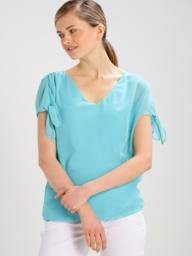

In [9]:
IPython.display.Image(filename='/kaggle/input/peoples/000019_0.jpg') 

In [33]:
print(image)

<PIL.Image.Image image mode=RGB size=192x256 at 0x7DFFBAF909D0>


In [10]:
ip_image = load_image('/kaggle/input/tshirts/000006_1.jpg').convert("RGB")

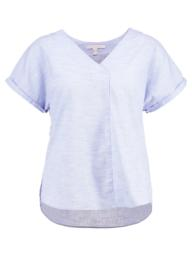

In [11]:
IPython.display.Image(filename='/kaggle/input/tshirts/000006_1.jpg') 

In [12]:
from transformers import pipeline
import numpy as np
import cv2
import insightface
from insightface.app import FaceAnalysis
from PIL import Image, ImageDraw


# Initialize face detection
app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# Initialize segmentation pipeline
segmenter = pipeline(model="mattmdjaga/segformer_b2_clothes")


def remove_face(img, mask):
    # Convert image to numpy array
    img_arr = np.asarray(img)
    
    # Run face detection
    faces = app.get(img_arr)
    
    # Get the first face
    faces = faces[0]['bbox']

    # Width and height of face
    w = faces[2] - faces[0]
    h = faces[3] - faces[1]

    # Make face locations bigger
    faces[0] = faces[0] - (w*0.5) # x left
    faces[2] = faces[2] + (w*0.5) # x right
    faces[1] = faces[1] - (h*0.5) # y top
    faces[3] = faces[3] + (h*0.2) # y bottom

    # Convert to [(x_left, y_top), (x_right, y_bottom)]
    face_locations = [(faces[0], faces[1]), (faces[2], faces[3])]

    # Draw black rect onto mask
    img1 = ImageDraw.Draw(mask)
    img1.rectangle(face_locations, fill=0)

    return mask

def segment_body(original_img, face=True):
    # Make a copy
    img = original_img.copy()
    
    # Segment image
    segments = segmenter(img)

    # Create list of masks
    segment_include = ["Hat", "Hair", "Sunglasses", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Face", "Left-leg", "Right-leg", "Left-arm", "Right-arm", "Bag","Scarf"]
    mask_list = []
    for s in segments:
        if(s['label'] in segment_include):
            mask_list.append(s['mask'])


    # Paste all masks on top of eachother 
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        current_mask = np.array(mask)
        final_mask = final_mask + current_mask
            
    # Convert final mask from np array to PIL image
    final_mask = Image.fromarray(final_mask)

    # Remove face
    if(face==False):
        final_mask = remove_face(img.convert('RGB'), final_mask)

    # Apply mask to original image
    img.putalpha(final_mask)

    return img, final_mask


def segment_torso(original_img):
    # Make a copy
    img = original_img.copy()
    
    # Segment image
    segments = segmenter(img)

    # Create list of masks
    segment_include = ["Upper-clothes", "Dress", "Belt", "Face", "Left-arm", "Right-arm"]
    mask_list = []
    for s in segments:
        if(s['label'] in segment_include):
            mask_list.append(s['mask'])


    # Paste all masks on top of eachother 
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        current_mask = np.array(mask)
        final_mask = final_mask + current_mask
            
    # Convert final mask from np array to PIL image
    final_mask = Image.fromarray(final_mask)

    # Remove face
    final_mask = remove_face(img.convert('RGB'), final_mask)

    # Apply mask to original image
    img.putalpha(final_mask)

    return img, final_mask


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [13]:
seg_image, mask_image = segment_body(image, face=False)

/opt/conda/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [19]:
pipeline.set_ip_adapter_scale(1.0)

In [20]:
final_image = pipeline(
    prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt="ugly, bad quality, bad anatomy, deformed feet, deformed face, deformed clothing, deformed skin, leggings, tights, stockings, bad skin, deformed body, deformed hands",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    strength=0.99,  # Reduced strength to 0.75 to prevent over-adjustment
    guidance_scale=9.5,  # Increased guidance scale for better adherence to the prompt
    num_inference_steps=200,  # Increased the number of inference steps for finer details
).images[0]


  0%|          | 0/198 [00:00<?, ?it/s]

In [21]:
final_image.save('/kaggle/working/final_image1.jpg')

# Display the final image


In [22]:
# Save the model for CPU usage
pipeline.to("cpu")
pipeline.save_pretrained("/kaggle/working/saved_model")

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

In [1]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/feature_extractor/ (stored 0%)
  adding: kaggle/working/saved_model/feature_extractor/preprocessor_config.json (deflated 48%)
  adding: kaggle/working/saved_model/vae/ (stored 0%)
  adding: kaggle/working/saved_model/vae/diffusion_pytorch_model.safetensors (deflated 8%)
  adding: kaggle/working/saved_model/vae/config.json (deflated 58%)
  adding: kaggle/working/saved_model/unet/ (stored 0%)
  adding: kaggle/working/saved_model/unet/diffusion_pytorch_model.safetensors (deflated 8%)
  adding: kaggle/working/saved_model/unet/config.json (deflated 61%)
  adding: kaggle/working/saved_model/tokenizer/ (stored 0%)
  adding: kaggle/working/saved_model/tokenizer/vocab.json (deflated 71%)
  adding: kaggle/working/saved_model/tokenizer/special_tokens_map.json (deflated 73%)
  adding: kaggle/working/saved_model/tokenizer/tokenizer_config.json (deflated 63%)
  adding: kaggle/

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained("/kaggle/working/saved_model", torch_dtype=torch.float32).to("cpu")

In [ ]:
# Load the images
image = load_image('/kaggle/input/peoples/000006_0.jpg').convert("RGB")
display(IPython.display.Image(filename='/kaggle/input/peoples/000006_0.jpg'))
ip_image = load_image('/kaggle/input/tshirts/000004_1.jpg').convert("RGB")
display(IPython.display.Image(filename='/kaggle/input/tshirts/000004_1.jpg'))

In [ ]:





# Initialize face detection on CPU
app = FaceAnalysis(providers=['CPUExecutionProvider'])
app.prepare(ctx_id=-1, det_size=(640, 640))

# Initialize segmentation pipeline
segmenter = pipeline(model="mattmdjaga/segformer_b2_clothes")

def remove_face(img, mask):
    img_arr = np.asarray(img)
    faces = app.get(img_arr)
    faces = faces[0]['bbox']
    w = faces[2] - faces[0]
    h = faces[3] - faces[1]
    faces[0] -= w * 0.5
    faces[2] += w * 0.5
    faces[1] -= h * 0.5
    faces[3] += h * 0.2
    face_locations = [(faces[0], faces[1]), (faces[2], faces[3])]
    img1 = ImageDraw.Draw(mask)
    img1.rectangle(face_locations, fill=0)
    return mask

def segment_body(original_img, face=True):
    img = original_img.copy()
    segments = segmenter(img)
    segment_include = ["Hat", "Hair", "Sunglasses", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Face", "Left-leg", "Right-leg", "Left-arm", "Right-arm", "Bag","Scarf"]
    mask_list = [s['mask'] for s in segments if s['label'] in segment_include]
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        final_mask += np.array(mask)
    final_mask = Image.fromarray(final_mask)
    if not face:
        final_mask = remove_face(img.convert('RGB'), final_mask)
    img.putalpha(final_mask)
    return img, final_mask

# Segment body and process the image


In [ ]:
seg_image, mask_image = segment_body(image, face=False)


In [ ]:
pipeline.set_ip_adapter_scale(1.0)


In [ ]:
final_image = pipeline(
    prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    strength=0.75,
    guidance_scale=9.5,
    num_inference_steps=250,
).images[0]

# Save and display the final image
final_image.save('/kaggle/working/final_image_cpu.jpg')
display(final_image)